# WCT other Analyses

Hereafter are the analyses that were not kept in our final analysis.

## Importations

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from WCT_analysis_utils import (run_SIGID, mandelbrot_law_fit, get_stars,
    mandelbrot_zipf, confidence_ellipse, old_pairwise_tests)

In [2]:
results_df = pd.read_csv(
    "./resources/dtw_resources/contours_with_category.csv",
    index_col=0, parse_dates=["start_dt", "stop_dt"])   
results_df["date"] = pd.to_datetime(results_df["start_dt"].dt.date)
results_df["year"] = results_df["date"].dt.year
results_df["clean_activation_state"] = results_df["activation_state"].copy()
results_df.loc[results_df.clean_activation_state == 'Control', 'clean_activation_state'] = "BEF"

# rename isolated whistles to -1 (singletons)
cat_counts = np.unique(results_df.category, return_counts=True)
for cat, count in zip(cat_counts[0], cat_counts[1]):
    if cat == 0:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1
    elif count == 1:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1

## SIGID

We use the 0.2-10 sec interval from analyses in main file.

In [3]:
# Identify SWTs (SIGID method)
the_interval = [0.2,10]
results_df = run_SIGID(results_df, interval=the_interval)
the_interval = "SWT_[0.2,10]"
print(f"Choosing interval: {the_interval}")
results_df['is_SW'] = results_df[the_interval].astype(int)

Choosing interval: SWT_[0.2,10]


## Zipf-Mandelbrot's law

For the interpretation, idk for now, but please use http://biorxiv.org/lookup/doi/10.1101/2023.01.11.523588 and https://www.mdpi.com/1099-4300/11/4/688.

### Regression

So what is the frequency of occurence of each WCT independantly?
We have 216 categories with 2-40 elements, let's represent them.

In [4]:
wct_no_swt_sizes = results_df[results_df["SWT_[0.2,10]"]==False]['category'].value_counts().drop(index=-1)
wct_sizes = results_df['category'].value_counts().drop(index=-1)
swt_sizes = results_df[results_df["SWT_[0.2,10]"]==True]['category'].value_counts()

WCTs:
	Zipf's fit : -0.76 * rank + 4.92
	Expecting slope ~ -1
	Mandelbrot's fit : 667.36/((rank + 14.41)**1.05)
	Exponent ~ 1, top_intercept ~ 1, bottom_intercept ~ 0

NSWTs:
	Zipf's fit : -0.73 * rank + 4.31
	Expecting slope ~ -1
	Mandelbrot's fit : 104.79/((rank + 2.20)**0.80)
	Exponent ~ 1, top_intercept ~ 1, bottom_intercept ~ 0

SWTs:
	Zipf's fit : -0.78 * rank + 4.54
	Expecting slope ~ -1
	Mandelbrot's fit : 71930.96/((rank + 33.78)**2.19)
	Exponent ~ 1, top_intercept ~ 1, bottom_intercept ~ 0



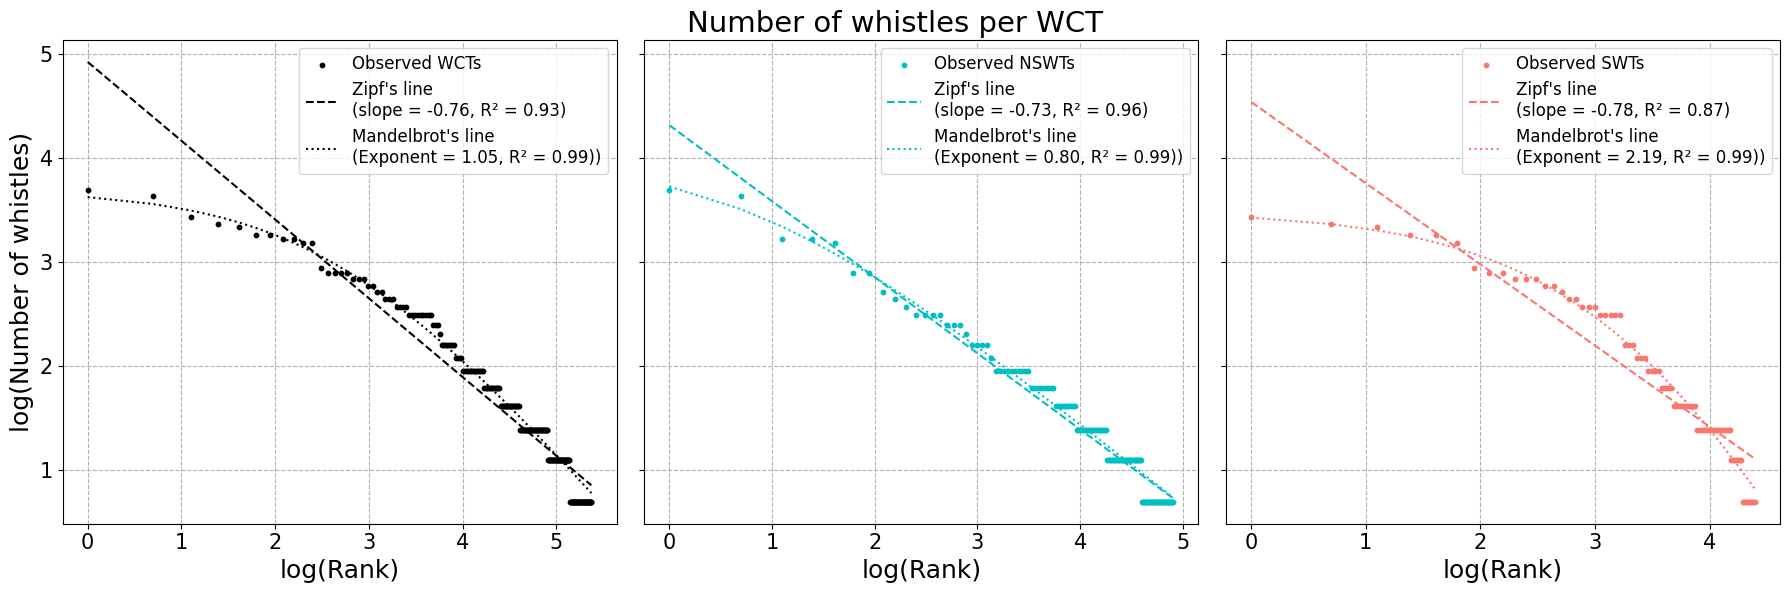

In [5]:
zip_3 = zip(
    [wct_sizes, wct_no_swt_sizes, swt_sizes], 
    ["WCTs", "NSWTs", "SWTs"],
    ["black", "#00BFC4", "#F8766D"]
    )

zipf_wct_fig, zipf_wct_ax = plt.subplots(1, 3, figsize=(18,6), sharey=True)
for i, (sizes, name, color) in enumerate(zip_3):
    sizes = sizes.sort_values()[::-1].to_numpy()
    zipf_wct_sizes = pd.DataFrame({"Rank":np.arange(1,len(sizes)+1), "Frequency": sizes})

    zipf_wct_ax[i].scatter(
        y=np.log(zipf_wct_sizes["Frequency"]), x=np.log(zipf_wct_sizes["Rank"]),
        s=10, color=color, label=f"Observed {name}"
    )

    # fit Zipf's law
    pearson_results = stats.linregress(
        np.log(zipf_wct_sizes["Rank"]), 
        np.log(zipf_wct_sizes["Frequency"]))
    slope, intercept, r_value, p_value, std_err = pearson_results

    zipf_wct_ax[i].plot(
        np.log(zipf_wct_sizes["Rank"]), 
        intercept + slope * np.log(zipf_wct_sizes["Rank"]), 
        linestyle='dashed', color=color, 
        label=f"Zipf's line\n(slope = {slope:.2f}, R² = {r_value**2:.2f})")

    print(f"{name}:")
    print(f"\tZipf's fit : {slope:.2f} * rank + {intercept:.2f}")
    print(f"\tExpecting slope ~ -1")

    # fit Mandelbrot's law
    mandelbot_results = mandelbrot_law_fit(zipf_wct_sizes)

    residuals = zipf_wct_sizes["Frequency"] - mandelbrot_zipf(zipf_wct_sizes["Rank"], *(mandelbot_results['c'], mandelbot_results['s'], mandelbot_results['b']))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((zipf_wct_sizes["Frequency"] - np.mean(zipf_wct_sizes["Frequency"]))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    zipf_wct_ax[i].plot(
        np.log(zipf_wct_sizes["Rank"]), 
        np.log(mandelbrot_zipf(zipf_wct_sizes["Rank"], *(mandelbot_results['c'], mandelbot_results['s'], mandelbot_results['b']))), 
        linestyle='dotted', color=color, 
        label=f"Mandelbrot's line\n(Exponent = {mandelbot_results['b']:.2f}, R² = {r_squared:.2f}))")

    print(f"\tMandelbrot's fit : {mandelbot_results['c']:.2f}/((rank + {mandelbot_results['s']:.2f})**{mandelbot_results['b']:.2f})")
    print(f"\tExponent ~ 1, top_intercept ~ 1, bottom_intercept ~ 0\n")

    # zipf_wct_ax.set_xscale('log')
    # zipf_wct_ax.set_yscale('log')
    zipf_wct_ax[i].set_xlabel('log(Rank)', fontsize=18)
    zipf_wct_ax[i].legend(prop={'size': 12})
    zipf_wct_ax[i].tick_params(axis='both', labelsize=15)
    zipf_wct_ax[i].grid(True, linestyle='--', alpha=1)
    zipf_wct_ax[i].set_axisbelow(True)

# Adjust layout to prevent label cutoff
zipf_wct_ax[0].set_ylabel('log(Number of whistles)', fontsize=18)
zipf_wct_fig.tight_layout()
zipf_wct_fig.subplots_adjust(wspace=0.05, top=0.93)
zipf_wct_fig.suptitle("Number of whistles per WCT", fontsize=21)
# zipf_wct_fig.savefig(f"/home/loic/Pictures/CDD/Zipf_law.pdf")
plt.show()

Logical results: it makes sense to find a relation between these plots, and we find that NSWTs fit a linear regression with R²=0.96, a strong correlation, that may show that these signals follow Zipf's law --> are structured for langage communication.

But could we find these distribution randomly ?

### Monte Carlo Simulation

Let's take a random subgroup A, and B its complement in our dataset. 
Let's compare their Zipf slopes.

100%|██████████| 1000/1000 [00:00<00:00, 1187.44it/s]


Mahalanobis distance of observed point: 7.6259
P-value (probability of obtaining a point with greater distance by chance): 2.3548e-13


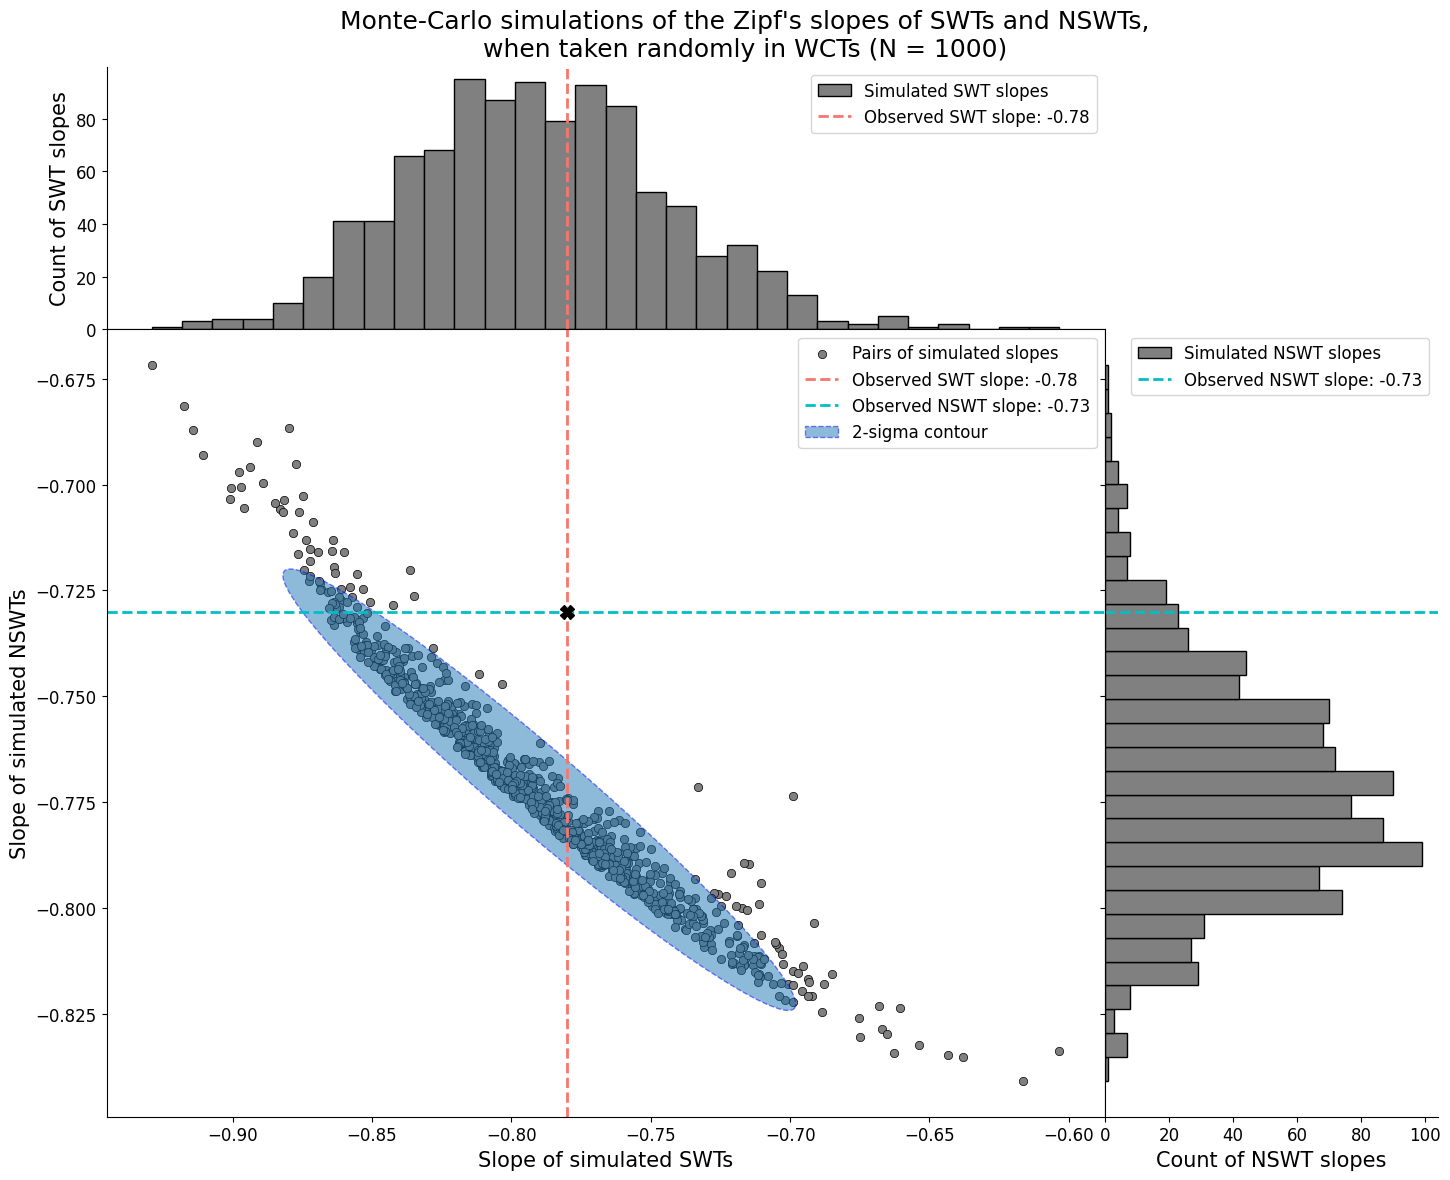

In [6]:
np.random.seed(42)
SWT_slope = -0.78
NSWT_slope = -0.73
N_simulations = 1000
proportion_of_swts = results_df[results_df["SWT_[0.2,10]"]].category.nunique()/results_df.category.nunique()

results = []
for i in tqdm(range(N_simulations), leave=True):
    # create random A and B subgroups
    new_order = np.random.permutation(wct_sizes.to_numpy())
    A_subgroup = new_order[:int(len(wct_sizes)*proportion_of_swts)]
    B_subgroup = new_order[int(len(wct_sizes)*proportion_of_swts):]    

    # compute zipf slopes
    local_results = {'simulation': i}
    for subgroup, name in zip([A_subgroup, B_subgroup], ["a", "b"]):
        subgroup = np.sort(subgroup)[::-1]
        df_subgroup_sizes = pd.DataFrame({"Rank":np.arange(1,len(subgroup)+1), "Frequency": subgroup})

        # fit regression
        pearson_results = stats.linregress(np.log(df_subgroup_sizes["Rank"]), np.log(df_subgroup_sizes["Frequency"]))
        slope, intercept, r_value, p_value, std_err = pearson_results    

        local_results[f'subgroup_{name}_slope'] = slope
        local_results[f'subgroup_{name}_r2'] = r_value**2
        local_results[f'subgroup_{name}_p_value'] = p_value
    
    local_results['slope_difference'] = local_results['subgroup_a_slope'] - local_results['subgroup_b_slope']
    results.append(local_results)
sim_results = pd.DataFrame(results)

# compute Mahalanobis distance
simulated_points = sim_results[['subgroup_a_slope', 'subgroup_b_slope']].values
mean_vector = np.mean(simulated_points, axis=0)
cov_matrix = np.cov(simulated_points.T)
observed_point = np.array([SWT_slope, NSWT_slope])
diff = observed_point - mean_vector
mahalanobis_dist = np.sqrt(diff.dot(np.linalg.inv(cov_matrix)).dot(diff.T))
# For a 2D normal distribution, the squared Mahalanobis distance follows a chi-squared 
# distribution with 2 degrees of freedom
p_value_mahalanobis = 1 - stats.chi2.cdf(mahalanobis_dist**2, df=2)

print(f"Mahalanobis distance of observed point: {mahalanobis_dist:.4f}")
print(f"P-value (probability of obtaining a point with greater distance by chance): {p_value_mahalanobis:.4e}")


# Show results in figure
if True:
    sim_fig, sim_ax = plt.subplots(
        2, 2, figsize=(15, 12), sharex="col", sharey="row",
        gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
    
    # Histogram of subgroup A slopes
    sim_ax[0, 0].hist(
        sim_results['subgroup_a_slope'], bins=30,
        facecolor="gray", edgecolor="black", label="Simulated SWT slopes")
    sim_ax[0, 0].axvline(SWT_slope, color="#F8766D", linestyle='dashed', 
                        linewidth=2, label=f'Observed SWT slope: {SWT_slope}')
    sim_ax[0, 0].set_ylabel('Count of SWT slopes', fontsize=15)
    sim_ax[0, 0].tick_params(axis='both', labelsize=12)
    sim_ax[0, 0].legend(prop={'size': 12})
    sim_ax[0, 0].spines['top'].set_visible(False)
    sim_ax[0, 0].spines['right'].set_visible(False)

    # Scatter plot of slopes
    sim_ax[1, 0].scatter(
        sim_results['subgroup_a_slope'], sim_results['subgroup_b_slope'], 
        color="gray", edgecolor='black', lw=0.5, label="Pairs of simulated slopes")
    sim_ax[1, 0].axvline(
        SWT_slope, color="#F8766D", linestyle='dashed', linewidth=2,
        label=f'Observed SWT slope: {SWT_slope}')
    sim_ax[1, 0].axhline(
        NSWT_slope, color="#00BFC4", linestyle='dashed', linewidth=2,
        label=f'Observed NSWT slope: {NSWT_slope}')
    sim_ax[1, 0].plot(
        SWT_slope, NSWT_slope, color="black", marker="X", markersize=10)
    sim_ax[1, 0].set_xlabel('Slope of simulated SWTs', fontsize=15)
    sim_ax[1, 0].set_ylabel('Slope of simulated NSWTs', fontsize=15)
    sim_ax[1, 0].tick_params(axis='both', labelsize=12)
    sim_ax[1, 0].legend(prop={'size': 12})

    # Histogram of subgroup B slopes
    sim_ax[1, 1].hist(
        sim_results['subgroup_b_slope'], bins=30, orientation='horizontal',
        facecolor="gray", edgecolor="black", label="Simulated NSWT slopes")
    sim_ax[1, 1].axhline(NSWT_slope, color="#00BFC4", linestyle='dashed', 
                        linewidth=2, label=f'Observed NSWT slope: {NSWT_slope}')
    sim_ax[1, 1].set_xlabel('Count of NSWT slopes', fontsize=15)
    sim_ax[1, 1].tick_params(axis='both', labelsize=12)
    sim_ax[1, 1].legend(prop={'size': 12})
    sim_ax[1, 1].spines['top'].set_visible(False)
    sim_ax[1, 1].spines['right'].set_visible(False)

    for n_std in [2]:
        confidence_ellipse(
            sim_results['subgroup_a_slope'], 
            sim_results['subgroup_b_slope'],
            sim_ax[1, 0], 
            n_std=n_std,
            edgecolor='blue' if n_std == 2 else 'gray',
            linestyle='--' if n_std == 2 else ':',
            alpha=0.5,
            label=f"{n_std}-sigma contour" if n_std == 2 else None
        )

    sim_ax[1, 0].legend(prop={'size': 12})

    sim_fig.suptitle(f"Monte-Carlo simulations of the Zipf's slopes of SWTs and NSWTs,\nwhen taken randomly in WCTs (N = {N_simulations})", fontsize=18)
    sim_fig.delaxes(ax=sim_ax[0,1])
    sim_fig.tight_layout()
    sim_fig.subplots_adjust(wspace=0, hspace=0)
    # sim_fig.savefig("/home/loic/Pictures/CDD/simulation_Zipf_law.pdf")
    plt.show()

# # Calculate p-value for obtaining the observed slopes or more extreme
# p_value_a = np.mean(sim_results['subgroup_a_slope'] >= SWT_slope)
# p_value_b = np.mean(sim_results['subgroup_b_slope'] <= NSWT_slope)
# p_value_diff = np.mean(sim_results['slope_difference'] >= abs(SWT_slope - NSWT_slope))

# print(f"Probability of randomly obtaining a subgroup SWT slope >= {SWT_slope}: {p_value_a:.4e}")
# print(f"Probability of randomly obtaining a subgroup NSWT slope <= {NSWT_slope}: {p_value_b:.4e}")
# print(f"Probability of randomly obtaining a slope difference >= {abs(SWT_slope - NSWT_slope):.2f}: {p_value_diff:.4e}")

This simulation shows that the probability of obtaining the combination of observed slopes from random sampling is very low (p-value << 0.001). 

So we can consider that this combination is specific to our dataset.

## Syntax

### Sequences

We're gonna assign a letter to each whistle :
- **S**: Signature whistle
- **N**: Non-signature whistle
- **W**: Whistle singleton

As well as two columns : time before next whistle and time since last whistle

Then, I will make statistics on 3-whistle sentences (excluding those with more than Xs between their elements).

In [7]:
# define whistle type
results_df["whistle_type"] = None
results_df.loc[results_df[results_df["SWT_[0.2,10]"] == True].index, "whistle_type"] = "S"
results_df.loc[results_df[results_df["SWT_[0.2,10]"] == False].index, "whistle_type"] = "N"
results_df.loc[results_df[results_df["category"] == -1].index, "whistle_type"] = "W"

# define intervals
results_df["next_whistle"] = None
results_df["next_whistle_delta"] = None
results_df["previous_whistle"] = None
results_df["previous_whistle_delta"] = None
for id_row, row in tqdm(results_df.iterrows(), total=len(results_df)):
    start_delta = (results_df.start_dt - row.start_dt).dt.total_seconds()
    results_df.loc[id_row, "next_whistle_delta"] = (start_delta[start_delta>0].sort_values()[0] if len(start_delta[start_delta>0])>0 else np.nan)
    results_df.loc[id_row, "next_whistle"] = (start_delta[start_delta>0].sort_values().index[0] if len(start_delta[start_delta>0])>0 else np.nan)
    results_df.loc[id_row, "previous_whistle_delta"] = (start_delta[start_delta<0].sort_values()[-1] if len(start_delta[start_delta<0])>0 else np.nan)
    results_df.loc[id_row, "previous_whistle"] = (start_delta[start_delta<0].sort_values().index[-1] if len(start_delta[start_delta<0])>0 else np.nan)

results_df[[
    'whistle_type', 'category', 'duration', 'start_dt', 'stop_dt',
    'clean_activation_state', 'fishing_net', 'behaviour', 'sequence',
    'next_whistle', 'next_whistle_delta', 'previous_whistle', 'previous_whistle_delta'
    ]].to_csv("./resources/dtw_resources/syntax_df.csv")

100%|██████████| 11575/11575 [00:46<00:00, 250.29it/s]


### Syntax: order 1

Under, the script that I will give to Hervé

In [8]:
# Select 3-whistles groups (should be done in 1-2 lines)
# Previous and Next whistles for each whistle (syntax order 1)
hg_df = pd.read_csv("./resources/dtw_resources/syntax_df.csv", parse_dates=["start_dt", "stop_dt"], index_col=0)
hg_df.sort_values(by="start_dt", inplace=True)

hg_df["3_groups"] = None   # will hold sequences of S, N and W
tol = 10                   # time delta between eacc whistle must be less than tol

for id_row, row in tqdm(hg_df.iterrows(), total=len(hg_df)):
    if (np.abs(row["previous_whistle_delta"]) <= tol) and (np.abs(row["next_whistle_delta"]) <= tol):
        prev_type = hg_df.loc[row["previous_whistle"], "whistle_type"]
        next_type = hg_df.loc[row["next_whistle"], "whistle_type"]
        hg_df.loc[id_row, "3_groups"] = prev_type+row["whistle_type"]+next_type
    else:
        hg_df.loc[id_row, "3_groups"] = np.nan  # no whistle within accepted bounds

100%|██████████| 11575/11575 [00:02<00:00, 4910.76it/s]


In [9]:
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
three_sequences_counts = pd.DataFrame(hg_df["3_groups"].value_counts()).T

print("Sequences of 3 whistles:")
print("\tCounts:")
display(three_sequences_counts)
print("\tProportion:")
display(100*three_sequences_counts/three_sequences_counts.T.sum()[0])

Sequences of 3 whistles:
	Counts:


,WWW,NWW,WNW,WWN,SWW,WWS,WSW,SSW,WSS,NNW,WNN,NWN,SWS,SSS,SWN,NSW,NWS,WNS,SNW,WSN,SNS,NNN,SSN,NSN,NSS,NNS,SNN
3_groups,7522,454,444,440,343,343,328,90,88,77,74,72,71,53,39,37,35,35,33,32,13,13,10,9,9,7,3


	Proportion:


,WWW,NWW,WNW,WWN,SWW,WWS,WSW,SSW,WSS,NNW,WNN,NWN,SWS,SSS,SWN,NSW,NWS,WNS,SNW,WSN,SNS,NNN,SSN,NSN,NSS,NNS,SNN
3_groups,70.47,4.25,4.16,4.12,3.21,3.21,3.07,0.84,0.82,0.72,0.69,0.67,0.67,0.50,0.37,0.35,0.33,0.33,0.31,0.30,0.12,0.12,0.09,0.08,0.08,0.07,0.03


## Old stats
### Behavioural state

In [ ]:
# test data
print("Fisher's exact tests:")
test_behaviours = old_pairwise_tests(results_df, "behaviour", "is_SW")
for test_behaviour in test_behaviours:
    if type(test_behaviour[0])==str and type(test_behaviour[1])==str:
        print("\t", test_behaviour[0], "VS", test_behaviour[1], f": (odds ratio={test_behaviour[3]:.2f})", f"{test_behaviour[2]:.2e}", get_stars(test_behaviour[2]))

Fisher's exact tests:
	 Socialising VS Foraging : (odds ratio=0.47) 2.39e-03 **
	 Socialising VS Travelling : (odds ratio=0.46) 1.98e-03 **
	 Socialising VS Attraction : (odds ratio=0.54) 1.52e-02 *
	 Socialising VS Milling : (odds ratio=0.34) 1.45e-04 ***
	 Foraging VS Travelling : (odds ratio=0.98) 8.41e-01 ns
	 Foraging VS Attraction : (odds ratio=1.14) 1.96e-01 ns
	 Foraging VS Milling : (odds ratio=0.72) 5.35e-02 ns
	 Travelling VS Attraction : (odds ratio=1.17) 1.20e-01 ns
	 Travelling VS Milling : (odds ratio=0.74) 6.93e-02 ns
	 Attraction VS Milling : (odds ratio=0.63) 7.18e-03 **


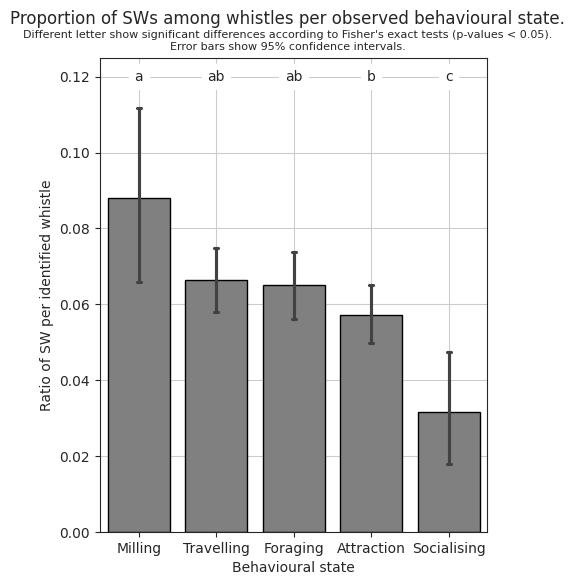

In [11]:
# Make plot
letters = ["a", "ab", "ab", "b", "c"] # manually from previous cell
behavioural_states = ["Milling", "Travelling", "Foraging", "Attraction", "Socialising"]

sns.set_style("ticks")
fig_behaviour, axs_behaviour = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="behaviour", y="is_SW",
    capsize=0.05, width=0.8, order=behavioural_states,
    n_boot=10000, seed=42, ax=axs_behaviour, 
    color="gray", edgecolor="black"
)
axs_behaviour.set_ylim(0,0.125)
for i, x in enumerate(behavioural_states):
    axs_behaviour.text(
        str(x), 0.12, letters[i], ha="center", va="center", fontsize=10,
        backgroundcolor="white"
    )
axs_behaviour.set_xlabel("Behavioural state")
axs_behaviour.set_ylabel("Ratio of SW per identified whistle")
fig_behaviour.suptitle("Proportion of SWs among whistles per observed behavioural state.")
fig_behaviour.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_behaviour.set_size_inches(5, 6)
fig_behaviour.subplots_adjust(
    top=0.9
)
axs_behaviour.xaxis.grid(True)
axs_behaviour.yaxis.grid(True)
# fig_behaviour.savefig("/home/loic/Pictures/CDD/barplot_behaviours.pdf")
plt.show()
sns.reset_orig()

### Beacon activation state

In [ ]:
# test data
print("Fisher's exact tests:")
test_beacons = old_pairwise_tests(results_df, "clean_activation_state", "is_SW")
for test_beacon in test_beacons:
    print("\t", test_beacon[0], "VS", test_beacon[1], f": (odds ratio={test_beacon[3]:.2f})", f"{test_beacon[2]:.2e}", get_stars(test_beacon[2]))

Fisher's exact tests:
	 DUR VS BEF : (odds ratio=1.70) 8.15e-08 ***
	 DUR VS DUR+AFT : (odds ratio=1.08) 7.04e-01 ns
	 DUR VS AFT : (odds ratio=0.85) 2.82e-01 ns
	 DUR VS BEF+DUR : (odds ratio=0.58) 5.80e-05 ***
	 BEF VS DUR+AFT : (odds ratio=0.63) 9.98e-03 **
	 BEF VS AFT : (odds ratio=0.50) 3.96e-05 ***
	 BEF VS BEF+DUR : (odds ratio=0.34) 3.02e-12 ***
	 DUR+AFT VS AFT : (odds ratio=0.79) 2.75e-01 ns
	 DUR+AFT VS BEF+DUR : (odds ratio=0.54) 1.00e-03 **
	 AFT VS BEF+DUR : (odds ratio=0.68) 3.41e-02 *


/tmp/ipykernel_65076/1747700944.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_beacon.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])


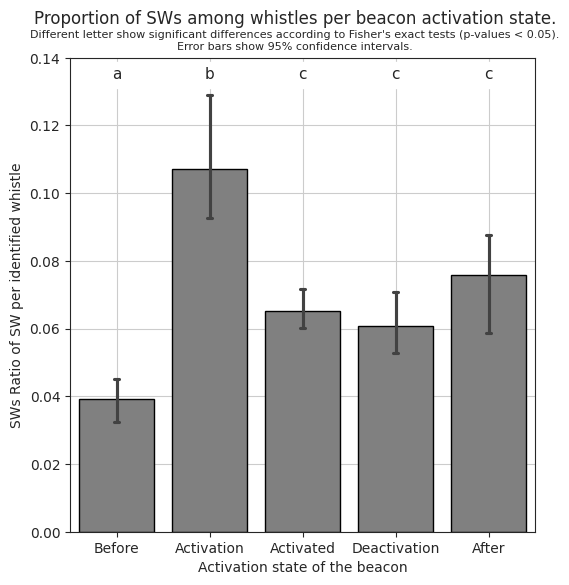

In [13]:
# Make plot
letters = ["a", "b", "c", "c", "c"] # manually from previous cell
activation_order = ["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"]

sns.set_style("ticks")
fig_beacon, axs_beacon = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="clean_activation_state", y="is_SW",
    capsize=0.05, width=0.8, order=activation_order,
    n_boot=30, seed=1, ax=axs_beacon,
    color="gray", edgecolor="black"
)
# since seaborn uses bootstrap, results are kinda different unfortunately.

axs_beacon.set_ylim(0,0.14)
for i, x in enumerate(activation_order):
    axs_beacon.text(
        str(x), 0.135, letters[i], ha="center", va="center", fontsize=11,
        backgroundcolor="white"
    )
axs_beacon.set_xlabel("Activation state of the beacon")
axs_beacon.set_ylabel("SWs Ratio of SW per identified whistle")
axs_beacon.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
fig_beacon.suptitle("Proportion of SWs among whistles per beacon activation state.")
fig_beacon.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_beacon.set_size_inches(6, 6)
fig_beacon.subplots_adjust(
    top=0.9
)
axs_beacon.xaxis.grid(True)
axs_beacon.yaxis.grid(True)
# fig_beacon.savefig("/home/loic/Pictures/CDD/barplot_beacons.pdf")
plt.show()
sns.reset_orig()

### Fishing net

In [ ]:
# test data
print("Fisher's exact tests:")
test_nets = old_pairwise_tests(results_df, "fishing_net", "is_SW")
for test_net in test_nets:
    print("\t", test_net[0], "VS", test_net[1], f": (odds ratio={test_net[3]:.2f})", f"{test_net[2]:.2e}", get_stars(test_net[2]))

Fisher's exact tests:
	 Absent VS Present : (odds ratio=1.33) 3.40e-04 ***


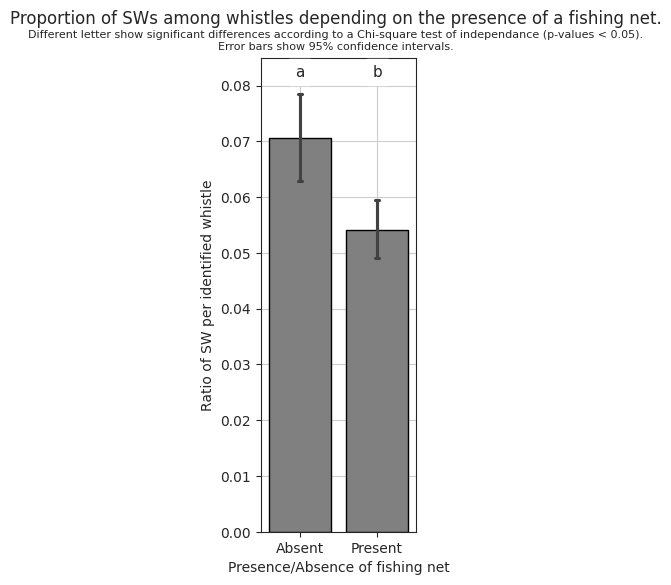

In [15]:
# Make plot
letters = ["a", "b"]

sns.set_style("ticks")
fig_net, axs_net = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="fishing_net", y="is_SW",
    capsize=0.05, width=0.8,
    n_boot=10000, seed=10, ax=axs_net,
    color="gray", edgecolor="black"
)
axs_net.set_ylim(0,0.085)
for i, x in enumerate(["Absent", "Present"]):
    axs_net.text(
        str(x), 0.08105, letters[i], ha="center", va="bottom", fontsize=11,
        backgroundcolor="white"
    )

fig_net.suptitle("Proportion of SWs among whistles depending on the presence of a fishing net.")
fig_net.text(
    0.5, 0.91,
    "Different letter show significant differences according to a Chi-square test of independance (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_net.set_size_inches(2, 6)
fig_net.subplots_adjust(
    top=0.9
)
axs_net.set_xlabel("Presence/Absence of fishing net")
axs_net.set_ylabel("Ratio of SW per identified whistle")
axs_net.xaxis.grid(True)
axs_net.yaxis.grid(True)
# fig_net.savefig("/home/loic/Pictures/CDD/barplot_net.pdf")
plt.show()
sns.reset_orig()

### Group size

The more dolphins, the more whistles (with a log increase). But are there also more SWs in proportion ?

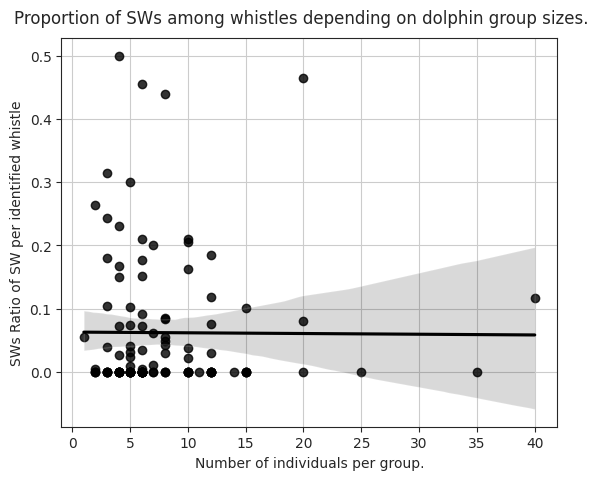

Spearman correlation: -0.04 (p-value 0.70)


In [16]:
ratio_df = results_df.groupby(['sequence', 'group_size'])['is_SW'].mean().reset_index()

sns.set_style("ticks")
fig_size, axs_size = plt.subplots(1,1)
sns.regplot(
    data=ratio_df, x='group_size', y='is_SW',
    scatter=True, ax=axs_size,
    color="black"
)
fig_size.suptitle("Proportion of SWs among whistles depending on dolphin group sizes.")
# fig_size.set_size_inches(2, 6)
fig_size.subplots_adjust(
    top=0.92
)
axs_size.set_xlabel("Number of individuals per group.")
axs_size.set_ylabel("SWs Ratio of SW per identified whistle")
axs_size.xaxis.grid(True)
axs_size.yaxis.grid(True)
# fig_size.savefig("/home/loic/Pictures/CDD/regplot_group_size.pdf")
plt.show()
sns.reset_orig()

r = stats.spearmanr(
    ratio_df["group_size"], 
    ratio_df["is_SW"])

print(f"Spearman correlation: {r[0]:.2f} (p-value {r[1]:.2f})")

### Interactions
#### Activation sequence VS behaviour

/tmp/ipykernel_65076/1504090358.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  interaction_axs.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])


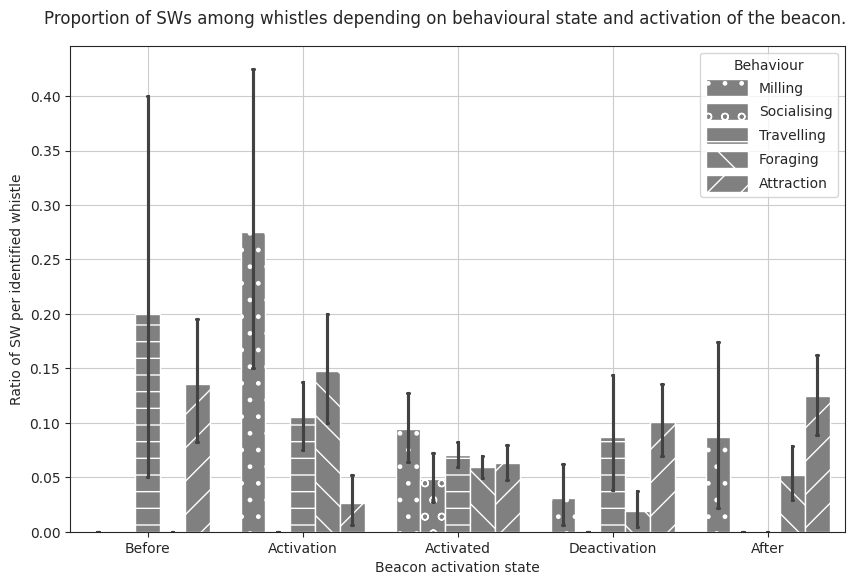

In [17]:
sns.set_style("ticks")
interaction_fig, interaction_axs = plt.subplots(1,1)
hue_order=["Milling", "Socialising", "Travelling", "Foraging", "Attraction"]
bars = sns.barplot(
    data=results_df, x="activation_state", y="is_SW", hue="behaviour",
    capsize=0.05, width=0.8, 
    order=["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"], 
    hue_order=hue_order,
    n_boot=10000, seed=42, ax=interaction_axs,
)

# Apply hatch patterns : ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
unique_colors = np.unique(np.array([bar.get_facecolor() for bar in bars.patches]), axis=0)
hatch_patterns = ['.', '-', '/', '\\', 'o']
for bar in bars.patches:
    color = bar.get_facecolor()
    index = [i for i, unique_color in enumerate(unique_colors) if np.all(unique_color == color)]
    bar.set_hatch(hatch_patterns[index[0]])
    bar.set_facecolor('gray')
interaction_axs.legend(title="Behaviour", handlelength=3, handleheight=1.5)

interaction_fig.set_size_inches(10, 6)
interaction_fig.suptitle("Proportion of SWs among whistles depending on behavioural state and activation of the beacon.")
interaction_fig.subplots_adjust(
    top=0.92
)
interaction_axs.set_xlabel("Beacon activation state")
interaction_axs.set_ylabel("Ratio of SW per identified whistle")
interaction_axs.xaxis.grid(True)
interaction_axs.yaxis.grid(True)
interaction_axs.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
# interaction_fig.savefig("/home/loic/Pictures/CDD/regplot_interaction_beahviour_beacon.pdf")
plt.show()
sns.reset_orig()

Too many variations and missing modalities, cannot easily determine true variations.

#### Fishing net interactions

The presence of a fishing has no effect alone. But maybe when considering interactions it reveals an effect?

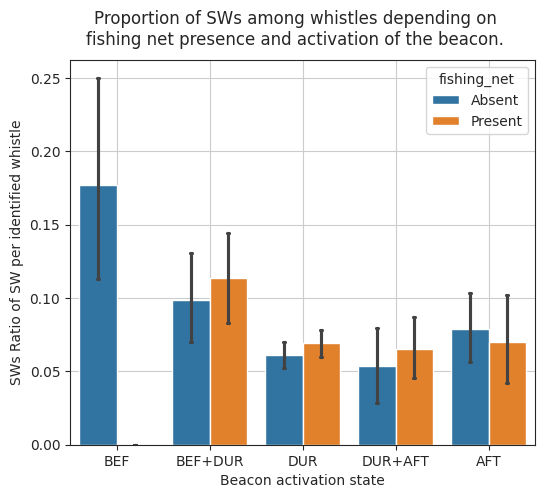

In [18]:
sns.set_style("ticks")
net_interaction_fig, net_interaction_axs = plt.subplots(1,1)
bars = sns.barplot(
    data=results_df, x="activation_state", y="is_SW", hue="fishing_net",
    capsize=0.05, width=0.8, 
    order=["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"], 
    hue_order=["Absent", "Present"],
    n_boot=10000, seed=42, ax=net_interaction_axs,
)

net_interaction_fig.set_size_inches(6, 5)
net_interaction_fig.suptitle("Proportion of SWs among whistles depending on\nfishing net presence and activation of the beacon.")
net_interaction_fig.subplots_adjust(top=0.88)
net_interaction_axs.set_xlabel("Beacon activation state")
net_interaction_axs.set_ylabel("SWs Ratio of SW per identified whistle")
net_interaction_axs.xaxis.grid(True)
net_interaction_axs.yaxis.grid(True)
plt.show()
sns.reset_orig()

Some interaction is visible for attraction and travelling. But nothing really surprising compared to fishing net effects alone.